# Forecasting NBA Game Statistics for Players in Upcoming Games

# Dataset
The dataset is from the 2022-23 and 2023-24 NBA seasons. It contains the game logs for every player.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('nba-player-gamelogs.csv')
df['dateUTC'] = pd.to_datetime(df['dateUTC'])
df

,season,dateUTC,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,blocks,turnovers,fieldGoalsAttempted,fieldGoalsMade,freeThrowsAttempted,freeThrowsMade,fouls,threesAttempted,threesMade,gamescore
0,2022,2023-03-31,1610612755,1610612761,1629001,PG,1,32.600000,13,3,...,1,1,9,5,4,3,2,3.0,0.0,13.9
1,2022,2023-03-31,1610612755,1610612761,200782,PF,1,25.716667,9,1,...,0,1,7,3,0,0,2,6.0,3.0,6.8
2,2022,2023-03-31,1610612755,1610612761,203954,C,1,33.566667,25,1,...,1,5,13,7,12,11,3,2.0,0.0,17.5
3,2022,2023-03-31,1610612755,1610612761,1630178,SG,1,36.516667,13,6,...,0,0,8,5,1,1,2,4.0,2.0,12.8
4,2022,2023-03-31,1610612755,1610612761,201935,SG,1,37.100000,23,11,...,1,6,14,9,2,2,2,6.0,3.0,21.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-02-23,1610612759,1610612758,1631104,PG,0,16.916667,4,1,...,0,1,4,1,2,2,2,2.0,0.0,1.2
63013,2023,2024-02-23,1610612759,1610612758,1626224,SF,0,11.300000,5,3,...,0,0,4,2,0,0,1,2.0,1.0,5.3
63014,2023,2024-02-23,1610612759,1610612758,1631103,PG,0,13.350000,5,2,...,0,1,6,2,0,0,0,2.0,1.0,3.3
63015,2023,2024-02-23,1610612759,1610612758,1628984,PG,0,0.000000,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


# Feature Engineering

In [90]:

def calculate_average_stats(row):

    # The stats whose weighted averages will be taken.
    stats = {'fieldGoalsAttempted': None, 'fieldGoalsMade': None, 'threesMade': None, 
             'freeThrowsAttempted': None, 'freeThrowsMade': None, 'points': None, 'steals': None, 
             'blocks': None, 'assists': None, 'reboundsTotal': None, 'reboundsOffensive': None,
             'reboundsDefensive': None, 'turnovers': None, 'fouls': None}
        
    for stat in stats.keys():
        if row['isStarter']:
            player_start_games = df[(df['dateUTC'] < row['dateUTC']) & (df['isStarter'])
                                    & (df['playerId']==row['playerId'])
                                   & (df['playerTeamId'] == row['playerTeamId'])]
            if len(player_start_games) == 0:
                # If there is no sample of the player as a starter, use the average of the
                # players that start and play the player's position.
                stats[stat] = df[(df['dateUTC'] < row['dateUTC']) & (df['isStarter']) 
                                 & (df['position']==row['position'])][stat].mean()
            else:
                # If there is a sample of the player as a starter, use the average they got
                # as a starter.
                weights = 0.98 ** (row['dateUTC'] - player_start_games['dateUTC']).dt.days
                stats[stat] = np.sum(weights * player_start_games[stat]) / np.sum(weights)
        else:
            player_bench_games = df[(df['dateUTC'] < row['dateUTC']) & ~(df['isStarter']) 
                                    & (df['playerId']==row['playerId'])
                                   & (df['playerTeamId'] == row['playerTeamId'])]
            if len(player_bench_games) == 0:
                # If there is no sample of the player as a bench player, use the average of the
                # bench players that play the player's position.
                stats[stat] = df[(df['dateUTC'] < row['dateUTC']) & ~(df['isStarter']) 
                                 & (df['position']==row['position'])][stat].mean()
            else:
                # If there is a sample of the player as a bench player, use the average they got
                # as a bench player.
                weights = 0.98 ** (row['dateUTC'] - player_bench_games['dateUTC']).dt.days
                stats[stat] = np.sum(weights * player_bench_games[stat]) / np.sum(weights)
    
    return pd.Series(stats)
    
df[['fieldGoalsAttemptedAvg', 'fieldGoalsMadeAvg', 'threesMadeAvg',
    'freeThrowsAttemptedAvg', 'freeThrowsMadeAvg', 'pointsAvg', 'stealsAvg', 'blocksAvg',
   'assistsAvg', 'reboundsTotalAvg', 'reboundsOffensiveAvg', 'reboundsDefensiveAvg', 
    'turnoversAvg', 'foulsAvg']
  ] = df.apply(calculate_average_stats, axis=1)
df

,season,dateUTC,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,freeThrowsMadeOppDRating,pointsOppDRating,stealsOppDRating,blocksOppDRating,assistsOppDRating,reboundsTotalOppDRating,reboundsOffensiveOppDRating,reboundsDefensiveOppDRating,turnoversOppDRating,foulsOppDRating
0,2022,2023-03-31,1610612755,1610612761,1629001,PG,1,32.600000,13,3,...,0.071504,0.423523,0.044002,0.017876,0.202136,0.108631,0.020626,0.088005,0.079754,0.079754
1,2022,2023-03-31,1610612755,1610612761,200782,PF,1,25.716667,9,1,...,0.079021,0.461650,0.020795,0.020795,0.085260,0.180917,0.039511,0.141406,0.062385,0.064465
2,2022,2023-03-31,1610612755,1610612761,203954,C,1,33.566667,25,1,...,0.103476,0.580013,0.016338,0.021785,0.093946,0.246437,0.061269,0.185168,0.063992,0.080330
3,2022,2023-03-31,1610612755,1610612761,1630178,SG,1,36.516667,13,6,...,0.067546,0.451914,0.025732,0.020907,0.112576,0.119009,0.017691,0.101319,0.069154,0.059505
4,2022,2023-03-31,1610612755,1610612761,201935,SG,1,37.100000,23,11,...,0.067546,0.451914,0.025732,0.020907,0.112576,0.119009,0.017691,0.101319,0.069154,0.059505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-02-23,1610612759,1610612758,1631104,PG,0,16.916667,4,1,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63013,2023,2024-02-23,1610612759,1610612758,1626224,SF,0,11.300000,5,3,...,0.058209,0.317910,0.031343,0.013433,0.062687,0.143284,0.026866,0.116418,0.044776,0.107463
63014,2023,2024-02-23,1610612759,1610612758,1631103,PG,0,13.350000,5,2,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63015,2023,2024-02-23,1610612759,1610612758,1628984,PG,0,0.000000,0,0,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045


In [43]:
def calculate_opp_stat_rating(row):
    
    # The defensive rating's will be calculated for these stats
    stats = {'fieldGoalsAttempted': None, 'fieldGoalsMade': None, 
             'threesMade': None, 'freeThrowsAttempted': None, 'freeThrowsMade': None,
             'points': None, 'steals': None, 'blocks': None,
            'assists': None, 'reboundsTotal': None, 'reboundsOffensive': None,
             'reboundsDefensive': None, 'turnovers': None, 'fouls': None}
    
    # All games the opposing team has played over the previous 50 days.
    opp_gms = df[(df['dateUTC'] < row['dateUTC']) & 
                 (df['dateUTC'] > (row['dateUTC'] - timedelta(days=50))) 
                 & (df['opposingTeamId'] == row['opposingTeamId'])
                 & (df['isStarter']==row['isStarter'])]
    
    for stat in stats.keys():
        # If the opponent has not played 20 games yet in the season, use all their games
        # from last season and the current season to estimate the opponent's rating
        if len(opp_gms['dateUTC'].unique()) < 20:
            opp_gms = df[(df['dateUTC'] < row['dateUTC']) 
                         & (df['opposingTeamId'] == row['opposingTeamId'])]
            
        # Get the total number of the stat accumulated by players with the given position against 
        # this team and divide by the total minutes played by those players
        
        stats[stat] = (opp_gms[opp_gms['position']==row['position']][stat].sum()
                        / opp_gms[opp_gms['position']==row['position']]['minutes'].sum())
    return pd.Series(stats)
    
df[['fieldGoalsAttemptedOppDRating', 'fieldGoalsMadeOppDRating', 
    'threesMadeOppDRating', 'freeThrowsAttemptedOppDRating', 'freeThrowsMadeOppDRating',
   'pointsOppDRating', 'stealsOppDRating', 'blocksOppDRating', 'assistsOppDRating', 
    'reboundsTotalOppDRating', 'reboundsOffensiveOppDRating', 'reboundsDefensiveOppDRating',
    'turnoversOppDRating', 'foulsOppDRating']] = df.apply(calculate_opp_stat_rating, axis=1)
df

C:\Users\sfedd\AppData\Local\Temp\ipykernel_15424\625961790.py:26: RuntimeWarning: invalid value encountered in scalar divide
  stats[stat] = (opp_gms[opp_gms['position']==row['position']][stat].sum()


,season,dateUTC,playerTeamId,opposingTeamId,playerId,position,isStarter,minutes,points,assists,...,freeThrowsMadeOppDRating,pointsOppDRating,stealsOppDRating,blocksOppDRating,assistsOppDRating,reboundsTotalOppDRating,reboundsOffensiveOppDRating,reboundsDefensiveOppDRating,turnoversOppDRating,foulsOppDRating
0,2022,2023-03-31,1610612755,1610612761,1629001,PG,1,32.600000,13,3,...,0.071504,0.423523,0.044002,0.017876,0.202136,0.108631,0.020626,0.088005,0.079754,0.079754
1,2022,2023-03-31,1610612755,1610612761,200782,PF,1,25.716667,9,1,...,0.079021,0.461650,0.020795,0.020795,0.085260,0.180917,0.039511,0.141406,0.062385,0.064465
2,2022,2023-03-31,1610612755,1610612761,203954,C,1,33.566667,25,1,...,0.103476,0.580013,0.016338,0.021785,0.093946,0.246437,0.061269,0.185168,0.063992,0.080330
3,2022,2023-03-31,1610612755,1610612761,1630178,SG,1,36.516667,13,6,...,0.067546,0.451914,0.025732,0.020907,0.112576,0.119009,0.017691,0.101319,0.069154,0.059505
4,2022,2023-03-31,1610612755,1610612761,201935,SG,1,37.100000,23,11,...,0.067546,0.451914,0.025732,0.020907,0.112576,0.119009,0.017691,0.101319,0.069154,0.059505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,2023,2024-02-23,1610612759,1610612758,1631104,PG,0,16.916667,4,1,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63013,2023,2024-02-23,1610612759,1610612758,1626224,SF,0,11.300000,5,3,...,0.058209,0.317910,0.031343,0.013433,0.062687,0.143284,0.026866,0.116418,0.044776,0.107463
63014,2023,2024-02-23,1610612759,1610612758,1631103,PG,0,13.350000,5,2,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63015,2023,2024-02-23,1610612759,1610612758,1628984,PG,0,0.000000,0,0,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045


In [109]:
# Get the dataset for machine learning.
# Only use game logs from the most recent rgular season. As of this comment, the most recent
# regular season is the 2023-24 season. 
ml_df = (df[df['season'] == max(df['season'].unique())]
         .drop(columns=['season', 'dateUTC', 'playerTeamId', 'opposingTeamId', 'playerId',
                       'position', 'minutes'])
         .dropna().copy())

ml_df

,isStarter,points,assists,reboundsDefensive,reboundsOffensive,reboundsTotal,steals,blocks,turnovers,fieldGoalsAttempted,...,freeThrowsMadeOppDRating,pointsOppDRating,stealsOppDRating,blocksOppDRating,assistsOppDRating,reboundsTotalOppDRating,reboundsOffensiveOppDRating,reboundsDefensiveOppDRating,turnoversOppDRating,foulsOppDRating
52,1,16,0,3,0,3,1,0,1,10,...,0.083307,0.558850,0.038182,0.010413,0.118018,0.161407,0.032976,0.128431,0.052067,0.072893
53,1,26,9,3,1,4,3,0,2,13,...,0.103938,0.528006,0.033260,0.074835,0.085922,0.289641,0.078993,0.210648,0.056819,0.083150
54,1,22,1,5,0,5,1,0,0,12,...,0.102696,0.577664,0.044012,0.012837,0.130204,0.095360,0.018339,0.077022,0.055016,0.067853
55,1,15,7,1,0,1,1,0,1,11,...,0.110226,0.616978,0.030062,0.020041,0.191821,0.130267,0.018610,0.111657,0.065849,0.057260
56,0,12,6,3,1,4,2,0,2,6,...,0.078243,0.486378,0.044408,0.004229,0.128996,0.109964,0.025376,0.084587,0.044408,0.103620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63012,0,4,1,0,1,1,0,0,1,4,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63013,0,5,3,2,0,2,0,0,0,4,...,0.058209,0.317910,0.031343,0.013433,0.062687,0.143284,0.026866,0.116418,0.044776,0.107463
63014,0,5,2,2,1,3,0,0,1,6,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045
63015,0,0,0,0,0,0,0,0,0,0,...,0.050261,0.362993,0.035369,0.009308,0.096798,0.124721,0.016754,0.107967,0.046538,0.080045


# Data Visualization

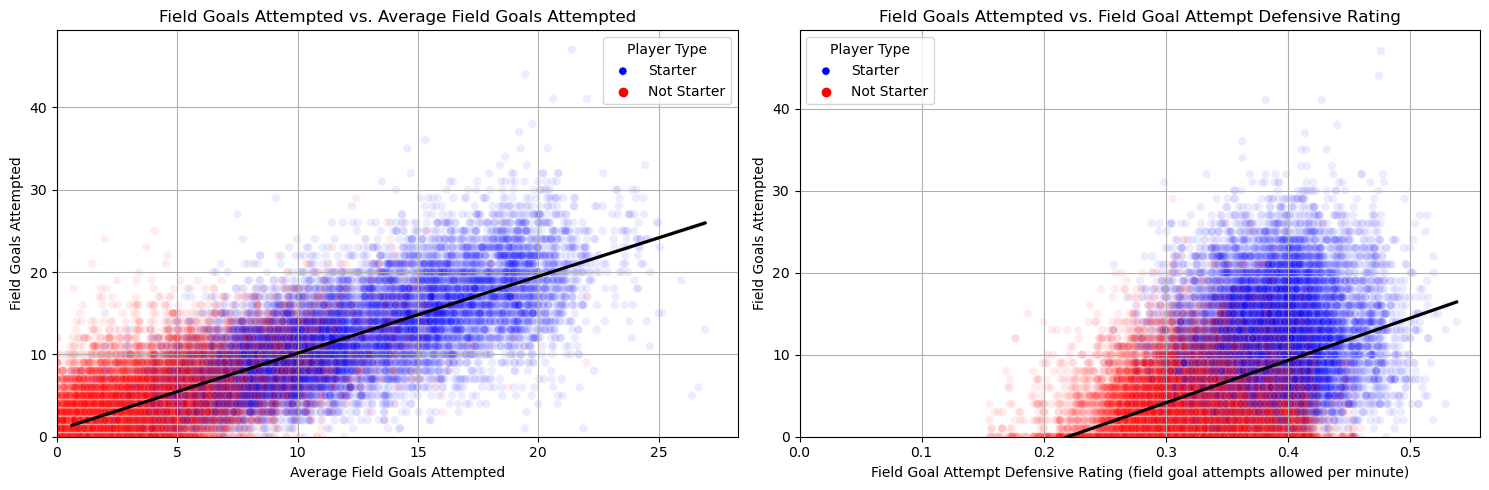

In [124]:
# Define a custom color palette for starters and non-starters
palette = {True: 'blue', False: 'red'}

# Create subplots with a larger plot size
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot with color based on isStarter and regression line for starters
scatter = sns.scatterplot(data=ml_df, x='fieldGoalsAttemptedAvg', y='fieldGoalsAttempted', 
                          hue='isStarter', palette=palette, alpha=0.075, marker='o', ax=axes[0])
starters_data = ml_df.query("isStarter == True")
sns.regplot(data=starters_data, x='fieldGoalsAttemptedAvg', y='fieldGoalsAttempted', 
            scatter=False, line_kws={'color':'black'}, ax=axes[0])
axes[0].set_title('Field Goals Attempted vs. Average Field Goals Attempted')
axes[0].set_xlabel('Average Field Goals Attempted')
axes[0].set_ylabel('Field Goals Attempted')
axes[0].grid(True)
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)

# Modify legend handles to ensure solid, same-sized dots
legend = axes[0].legend(title='Player Type', labels=['Starter', 'Not Starter'])
for lh in legend.legend_handles:
    lh.set_alpha(1)  # Set alpha to 1 for solid dots

# Scatter plot with oppdrating and regression line
scatter = sns.scatterplot(data=ml_df, x='fieldGoalsAttemptedOppDRating', y='fieldGoalsAttempted', 
                          hue='isStarter', palette=palette, alpha=0.075, marker='o', ax=axes[1])
sns.regplot(data=ml_df, x='fieldGoalsAttemptedOppDRating', y='fieldGoalsAttempted', 
            scatter=False, line_kws={'color':'black'}, ax=axes[1])
axes[1].set_title('Field Goals Attempted vs. Field Goal Attempt Defensive Rating')
axes[1].set_xlabel('Field Goal Attempt Defensive Rating (field goal attempts allowed per minute)')
axes[1].set_ylabel('Field Goals Attempted')
axes[1].grid(True)
axes[1].set_xlim(left=0)
axes[1].set_ylim(bottom=0)  # Optional: Set ylim for the second subplot if needed

# Modify legend handles for the second subplot as well
legend = axes[1].legend(title='Player Type', labels=['Starter', 'Not Starter'])
for lh in legend.legend_handles:
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

# Train the Linear Regressions with Machine Learning

In [112]:
# Player averages of each statistic to be predicted.
player_averages = [
    'fieldGoalsAttemptedAvg', 'fieldGoalsMadeAvg', 'threesMadeAvg',
    'freeThrowsAttemptedAvg', 'freeThrowsMadeAvg', 'pointsAvg', 'assistsAvg',
    'reboundsTotalAvg', 'reboundsOffensiveAvg', 'reboundsDefensiveAvg',
    'turnoversAvg', 'stealsAvg', 'blocksAvg', 'foulsAvg'
]

# Opposing defense's rating against each statistic to be predicted.
defensive_ratings = [
    'fieldGoalsAttemptedOppDRating', 'fieldGoalsMadeOppDRating',
    'threesMadeOppDRating', 'freeThrowsAttemptedOppDRating', 'freeThrowsMadeOppDRating',
    'pointsOppDRating', 'assistsOppDRating', 'reboundsTotalOppDRating', 
    'reboundsOffensiveOppDRating', 'reboundsDefensiveOppDRating', 'turnoversOppDRating', 
    'stealsOppDRating', 'blocksOppDRating', 'foulsOppDRating'
]

# Statistics to be predicted.
targets = ['fieldGoalsAttempted', 'fieldGoalsMade', 'threesMade', 
           'freeThrowsAttempted', 'freeThrowsMade', 'points', 'assists',
           'reboundsTotal', 'reboundsOffensive', 'reboundsDefensive', 
           'turnovers', 'steals', 'blocks', 'fouls']

# Split the machine learning dataset 80% for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(
    ml_df[player_averages + defensive_ratings], ml_df[targets], test_size=0.2, random_state=42
)

# Use machine learning to find the weights for each multivariable regression.
# For each statistic, the regression considers the player's average of that statistic and
# the opposing defense's strength against that statistic.
for target in targets:
    # Extract the corresponding average and defensive rating features
    X = ml_df[[f'{target}Avg', f'{target}OppDRating']]
    y = ml_df[target]
    
    # Get the training and test sets for the current features.
    X_train_target, X_test_target = (X_train[[f'{target}Avg', f'{target}OppDRating']],
                                    X_test[[f'{target}Avg', f'{target}OppDRating']])
    
    # Get the training and test sets for the current target statistic.
    y_train_target, y_test_target = y_train[target], y_test[target]
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train_target, y_train_target)
    
    # Compute evaluation metrics for the test set
    test_y_pred = model.predict(X_test_target) # Make predictions on the test set.
    test_rmse = mean_squared_error(y_test_target, test_y_pred, squared=False)
    r2 = r2_score(y_test_target, test_y_pred)
    
    # Compute evaluation metrics for training set
    train_y_pred = model.predict(X_train_target) # Make predictions on the training set.
    train_rmse = mean_squared_error(y_train_target, train_y_pred, squared=False)
    train_r2 = r2_score(y_train_target, train_y_pred)

    # Print evaluation metrics for training set
    print(f"Training Set Evaluation Metrics for {target}:")
    print("Training Set RMSE:", round(train_rmse, 3))
    print("Training Set R-squared:", round(train_r2, 3))

    # Print evaluation metrics for testing set
    print(f"Testing Set Evaluation Metrics for {target}:")
    print("Testing Set RMSE:", round(test_rmse, 3))
    print("Testing Set R-squared:", round(r2, 3))
                  
        # Compute and print correlation coefficients
    correlation_target_avg = X[f'{target}Avg'].corr(y)
    correlation_target_drating = X[f'{target}OppDRating'].corr(y)
    correlation_avg_drating = X.corr().iloc[0, 1]  # Correlation between avg and oppDRating
    print(f"Correlation between {target} and {target}Avg:", round(correlation_target_avg, 3))
    print(f"Correlation between {target} and {target}OppDRating:", round(correlation_target_drating, 3))
    print(f"Correlation between {target}Avg and {target}OppDRating:", round(correlation_avg_drating, 3))
    
    # Get the coefficients and intercept
    coefficients = model.coef_
    intercept = round(model.intercept_, 3)
    
    # Print the linear equation and R-squared for each regression
    coef1 = round(coefficients[0], 3)
    coef2 = round(coefficients[1], 3)
    lin_equation = f"{target} = {intercept} + ({coef1} * {target}Avg) + ({coef2} * {target}OppDRating)"
    print("Linear Equation:", lin_equation)
    print()

Training Set Evaluation Metrics for fieldGoalsAttempted:
Training Set RMSE: 3.412
Training Set R-squared: 0.719
Testing Set Evaluation Metrics for fieldGoalsAttempted:
Testing Set RMSE: 3.374
Testing Set R-squared: 0.723
Correlation between fieldGoalsAttempted and fieldGoalsAttemptedAvg: 0.848
Correlation between fieldGoalsAttempted and fieldGoalsAttemptedOppDRating: 0.418
Correlation between fieldGoalsAttemptedAvg and fieldGoalsAttemptedOppDRating: 0.472
Linear Equation: fieldGoalsAttempted = -0.604 + (0.949 * fieldGoalsAttemptedAvg) + (2.956 * fieldGoalsAttemptedOppDRating)

Training Set Evaluation Metrics for fieldGoalsMade:
Training Set RMSE: 2.136
Training Set R-squared: 0.6
Testing Set Evaluation Metrics for fieldGoalsMade:
Testing Set RMSE: 2.155
Testing Set R-squared: 0.596
Correlation between fieldGoalsMade and fieldGoalsMadeAvg: 0.773
Correlation between fieldGoalsMade and fieldGoalsMadeOppDRating: 0.37
Correlation between fieldGoalsMadeAvg and fieldGoalsMadeOppDRating: 0.443

Because the correlation coefficients between the dependent and independent variables for the steals and fouls regression is very low (< 0.05), I will only consider single variable regressions for steals and fouls, where the independent variable is just the average that was engineered.

In [104]:
X_steals = ml_df[['stealsAvg']]
y_steals = ml_df['steals']

# Split the data into training and testing sets for steals regression
X_steals_train, X_steals_test, y_steals_train, y_steals_test = train_test_split(
                                                X_steals, y_steals, test_size=0.2, random_state=42)

# Fit a linear regression model for steals
model_steals = LinearRegression()
model_steals.fit(X_steals_train, y_steals_train)

# Make predictions for steals
y_steals_pred = model_steals.predict(X_steals_test)

# Compute evaluation metrics for steals
mse_steals = mean_squared_error(y_steals_test, y_steals_pred)
rmse_steals = mean_squared_error(y_steals_test, y_steals_pred, squared=False)
r2_steals = r2_score(y_steals_test, y_steals_pred)

# Print the linear equation and R-squared for steals
linear_equation_steals = (f"steals = {round(model_steals.intercept_, 3)} +" 
                          +f"({round(model_steals.coef_[0], 3)} * stealsAvg)")
print("Linear Equation for steals regression:", linear_equation_steals)
print("R-squared for steals regression:", round(r2_steals, 3))

Linear Equation for steals regression: steals = 0.171 +(0.714 * stealsAvg)
R-squared for steals regression: 0.164


In [102]:

X_fouls = ml_df[['foulsAvg']]
y_fouls = ml_df['fouls']

# Split the data into training and testing sets for fouls regression
X_fouls_train, X_fouls_test, y_fouls_train, y_fouls_test = train_test_split(
                                                    X_fouls, y_fouls, test_size=0.2, random_state=42)

# Fit a linear regression model for fouls
model_fouls = LinearRegression()
model_fouls.fit(X_fouls_train, y_fouls_train)

# Make predictions for fouls
y_fouls_pred = model_fouls.predict(X_fouls_test)

# Compute evaluation metrics for fouls
mse_fouls = mean_squared_error(y_fouls_test, y_fouls_pred)
rmse_fouls = mean_squared_error(y_fouls_test, y_fouls_pred, squared=False)
r2_fouls = r2_score(y_fouls_test, y_fouls_pred)

# Print the linear equation and R-squared for fouls
linear_equation_fouls = (f"fouls = {round(model_fouls.intercept_, 3)}"
                        + f" + ({round(model_fouls.coef_[0], 3)} * foulsAvg)")
print("Linear Equation for fouls regression:", linear_equation_fouls)
print("R-squared for fouls regression:", round(r2_fouls, 3))

Linear Equation for fouls regression: fouls = 0.254 + (0.814 * foulsAvg)
R-squared for fouls regression: 0.306


# Use the model

In [114]:
def projections_model(model_input):
    projections = {
        "fieldGoalsAttempted": 0, "fieldGoalsMade": 0, "threesMade": 0,
        "freeThrowsAttempted": 0, "freeThrowsMade": 0, "points": 0,
        "assists": 0, "reboundsTotal": 0, "reboundsOffensive": 0,  "reboundsDefensive": 0,
        "turnovers": 0, "steals": 0, "blocks": 0, "fouls": 0
    }
    
    for stat, features in model_input.items():
        if stat == "fieldGoalsAttempted":
            projections[stat] = (-0.604 + 0.949 * features['average']
                                 + 2.956 * features['defensive_rating'])
        elif stat == "fieldGoalsMade":
            projections[stat] = (-0.367 + 0.925 * features['average']
                                 + 3.902  * features['defensive_rating'])
        elif stat == "threesMade":
            projections[stat] = (-0.02 + 0.856 * features['average']
                                 + 3.39 * features['defensive_rating'])
        elif stat == "freeThrowsAttempted":
            projections[stat] = (-0.08 + 0.874 * features['average']
                                 + 3.212 * features['defensive_rating'])
        elif stat == "freeThrowsMade":
            projections[stat] = (-0.046 + 0.864 * features['average']
                                 + 3.219 * features['defensive_rating'])
        elif stat == "points":
            projections[stat] = (-0.778 + 0.928 * features['average']
                                 + 3.307 * features['defensive_rating'])
        elif stat == "assists":
            projections[stat] = (-0.004 + 0.931 * features['average']
                                 + 1.789 * features['defensive_rating'])
        elif stat == "reboundsTotal":
            projections[stat] = (0.059 + 0.931 * features['average']
                                 + 1.392 * features['defensive_rating'])
        elif stat == "reboundsOffensive":
            projections[stat] = (0.061 + 0.815 * features['average']
                                 + 2.08 * features['defensive_rating'])
        elif stat == "reboundsDefensive":
            projections[stat] = (-0.007 + 0.905 * features['average']
                                 + 1.967 * features['defensive_rating'])
        elif stat == "turnovers":
            projections[stat] = (-0.018 + 0.846 * features['average'] 
                                 + 3.354 * features['defensive_rating'])
        elif stat == "steals":
            projections[stat] = 0.171 + 0.714 * features['average']
        elif stat == "blocks":
            projections[stat] = (0.027 + 0.747 * features['average']
                                 + 3.439 * features['defensive_rating'])
        elif stat == "fouls":
            projections[stat] = 0.254 + 0.814 * features['average']

    return projections

Use the model to make projections that can be used to calculate the predicted game score.

Game Score = Points + 0.4 × Field Goals Made - 0.7 × Field Goals Attempted - 0.4 × (Free Throws Attempted - Free Throws Made) + 0.7 × Offensive Rebounds + 0.3 × Defensive Rebounds + Steals + 0.7 × Assists + 0.7 × Blocks - 0.4 × Personal Fouls - Turnovers

In [115]:
# Calculate the actual gamescores for instances in the test set
y_test['gamescore'] = (y_test['points'] + 0.4*y_test['fieldGoalsMade'] 
                - 0.7*y_test['fieldGoalsAttempted']
                - 0.4*(y_test['freeThrowsAttempted'] - y_test['freeThrowsMade'])
                + 0.7*y_test['reboundsOffensive'] + 0.3*y_test['reboundsDefensive']
                + y_test['steals'] + 0.7*y_test['assists']
                + 0.7*y_test['blocks'] - 0.4*y_test['fouls']
                - y_test['turnovers'])

# Calculate the actual gamescores for instances in the training set
y_train['gamescore'] = (y_train['points'] + 0.4*y_train['fieldGoalsMade'] 
                - 0.7*y_train['fieldGoalsAttempted']
                - 0.4*(y_train['freeThrowsAttempted'] - y_train['freeThrowsMade'])
                + 0.7*y_train['reboundsOffensive'] + 0.3*y_train['reboundsDefensive']
                + y_train['steals'] + 0.7*y_train['assists']
                + 0.7*y_train['blocks'] - 0.4*y_train['fouls']
                - y_train['turnovers'])

def predict_gamescore(row):
    # Dictionary of the explanatory variables for each statistic
    features = {
        "fieldGoalsAttempted": {"average": row['fieldGoalsAttemptedAvg'], 
                                "defensive_rating": row['fieldGoalsAttemptedOppDRating']},
        "fieldGoalsMade": {"average": row['fieldGoalsMadeAvg'], 
                           "defensive_rating": row['fieldGoalsMadeOppDRating']},
        "threesMade": {"average": row['threesMadeAvg'], 
                       "defensive_rating": row['threesMadeOppDRating']},
        "freeThrowsAttempted": {"average": row['freeThrowsAttemptedAvg'], 
                                "defensive_rating": row['freeThrowsAttemptedOppDRating']},
        "freeThrowsMade": {"average": row['freeThrowsMadeAvg'],
                           "defensive_rating": row['freeThrowsMadeOppDRating']},
        "points": {"average": row['pointsAvg'], 
                   "defensive_rating": row['pointsOppDRating']},
        "assists": {"average": row['assistsAvg'], 
                    "defensive_rating": row['assistsOppDRating']},
        "reboundsTotal": {"average": row['reboundsTotalAvg'], 
                          "defensive_rating": row['reboundsTotalOppDRating']},
        "reboundsOffensive": {"average": row['reboundsOffensiveAvg'], 
                          "defensive_rating": row['reboundsOffensiveOppDRating']},
        "reboundsDefensive": {"average": row['reboundsDefensiveAvg'], 
                          "defensive_rating": row['reboundsDefensiveOppDRating']},
        "turnovers": {"average": row['turnoversAvg'], 
                      "defensive_rating": row['turnoversOppDRating']},
        "steals": {"average": row['stealsAvg']},
        "blocks": {"average": row['blocksAvg'], 
                   "defensive_rating": row['blocksOppDRating']},
        "fouls": {"average": row["foulsAvg"]}
    }
    
    projections = projections_model(features)
    game_score = (projections['points'] + 0.4*projections['fieldGoalsMade'] 
                - 0.7*projections['fieldGoalsAttempted']
                - 0.4*(projections['freeThrowsAttempted'] - projections['freeThrowsMade'])
                + 0.7*projections['reboundsOffensive'] + 0.3*projections['reboundsDefensive']
                + projections['steals'] + 0.7*projections['assists']
                + 0.7*projections['blocks'] - 0.4*projections['fouls']
                - projections['turnovers'])
    return game_score
                

X_test['predictedGamescore'] = X_test.apply(lambda row: predict_gamescore(row), axis=1)
X_train['predictedGamescore'] = X_train.apply(lambda row: predict_gamescore(row), axis=1) 

# Calculate Root Mean Squared Error (RMSE) for predicted game scores
rmse_test = np.sqrt(mean_squared_error(y_test['gamescore'], X_test['predictedGamescore']))
rmse_train = np.sqrt(mean_squared_error(y_train['gamescore'], X_train['predictedGamescore']))

print("Root Mean Squared Error (RMSE) for test set:", rmse_test)
print("Root Mean Squared Error (RMSE) for training set:", rmse_train)

Root Mean Squared Error (RMSE) for test set: 5.592252949502466
Root Mean Squared Error (RMSE) for training set: 5.5250962401405


# Time series of game score forecasts for example players across a whole season

C:\Users\sfedd\AppData\Local\Temp\ipykernel_15424\1848745336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_player_df['predictedGamescore'] = example_player_df.apply(


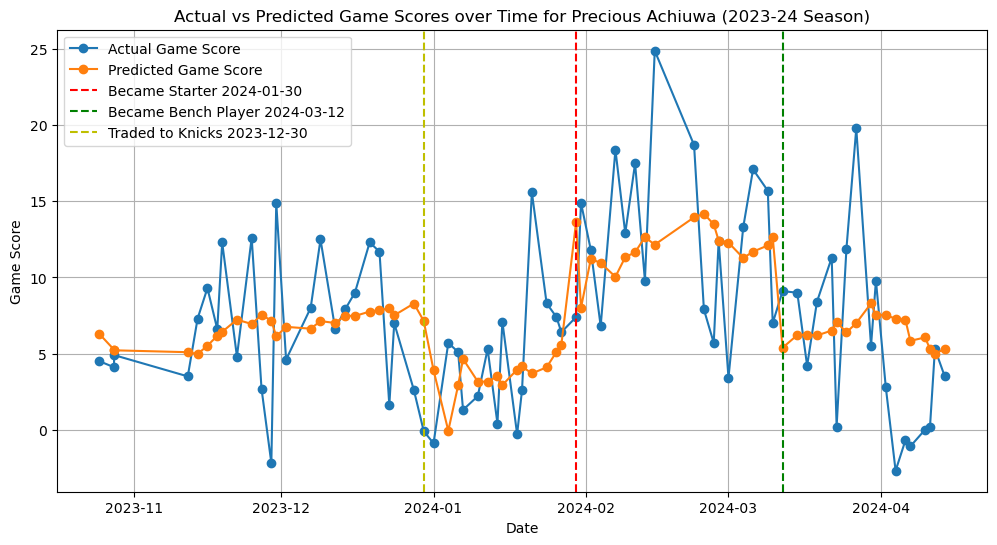

In [119]:
example_player_df = df[df['playerId'] == 1630173]  # This is Precious Achuiwa's gamelogs

# Predict gamescore for each game
example_player_df['predictedGamescore'] = example_player_df.apply(
    lambda row: predict_gamescore(row), axis=1)

# Get all the games played in the most recent season for the player
example_player_df = (example_player_df[example_player_df['season'] == 2023]
                    .sort_values(by='dateUTC'))

# Convert the 'date' column to datetime format
example_player_df['dateUTC'] = pd.to_datetime(example_player_df['dateUTC'])

# Set the 'date' column as the index
example_player_df.set_index('dateUTC', inplace=True)

# Plot the actual and predicted game scores over time
plt.figure(figsize=(12, 6))
plt.plot(example_player_df.index, example_player_df['gamescore'], label='Actual Game Score', 
         marker='o')
plt.plot(example_player_df.index, example_player_df['predictedGamescore'], 
         label='Predicted Game Score', marker='o')

# Plot the date when Julius Randle got injured. After Randle got injured, Achiuwa became a starter.
plt.axvline(x=pd.Timestamp('2024-01-30'), color='r', linestyle='--', 
            label='Became Starter 2024-01-30')

# Plot the date when Achiuwa became a bench player again.
plt.axvline(x=pd.Timestamp('2024-03-12'), color='g', linestyle='--', 
            label='Became Bench Player 2024-03-12')

# Plot the date when Achiuwa got traded to the New York Knicks.
plt.axvline(x=pd.Timestamp('2023-12-30'), color='y', linestyle='--', 
            label='Traded to Knicks 2023-12-30')

plt.xlabel('Date')
plt.ylabel('Game Score')
plt.title('Actual vs Predicted Game Scores over Time for Precious Achiuwa (2023-24 Season)')
plt.legend()
plt.grid(True)
plt.show()